In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from argopy import IndexFetcher as ArgoIndexFetcher

In [101]:
df_buoy = pd.read_pickle('atlantic_ocean_[-80,-39,0,50,2020-06-01,2021-07].pkl')

LIMITS = { 'lat1': 20, 'lat2': 41, 'lon1': -70, 'lon2': -49}

In [102]:
TIME_LIMITS = ('1990-01-01', '2021-7')

def get_data(gps_limits, time_limits):
    index_loader = ArgoIndexFetcher(cache=True)
    region_and_time = [gps_limits['lon1'], gps_limits['lon2'], 
                       gps_limits['lat1'], gps_limits['lat2'], 
                       TIME_LIMITS[0], TIME_LIMITS[1]] # up to june (exclusive last bound)
    idx = index_loader.region(region_and_time)

    df_buoy = idx.to_dataframe()
    df_buoy.to_pickle(f'argoindex_{region_and_time}.pkl')

    # Clean out ones w/o lat lon
    df_buoy = df_buoy.dropna(subset=['latitude', 'longitude'])

    print('!--- Sanity checks for data retrieved ---!')
    list_buoy_ids = df_buoy.wmo.unique()
    print('list of buoys retrieved ', list_buoy_ids, 'from ', region_and_time)
    print('num retrieved: ', len(list_buoy_ids))
    return df_buoy 

df_buoy = get_data(LIMITS, TIME_LIMITS)

!--- Sanity checks for data retrieved ---!
list of buoys retrieved  [  41951 4900149 4900147 4900148 4900151 4900187 4900228 4900132 4900159
 4900160 4900133 4900150 4900230 4900229 4900220 4900184 4900183 4900186
 4900221 4900270 4900271 4900272 4900273 4900233 4900235 4900158 4900135
 4900185 4900268 4900249 1900022 4900250 4900366 4900367 4900361 4900365
 4900364 4900360 4900362 4900232 4900363 4900182 4900424 4900425 4900382
 4900429 4900227 4900438 4900383 4900436 4900417 4900416 4900441 4900443
 4900442 4900446 4900411 4900353 4900435 4900445 4900440 4900420 4900412
 4900437 4900439 1900039 4900457 4900458 4900459 4900461 4900423 4900428
 4900210 4900419 4900470 4900471 4900545 4900544 4900455 4900548 4900549
 4900551 4900552 4900469 4900214 4900415 4900560 4900559 4900562 4900563
 4900136 4900498 4900460 4900466 1900276 4900561 4900567 4900320 4900582
 4900589 4900218 4900497 4900578 4900594 4900593 4900213 4900600 4900525
 4900463 4900602 4900579 4900599 4900604 4900613 4900614

In [103]:
df_buoy = pd.read_pickle("argoindex_[-70, -49, 20, 41, '1990-01-01', '2021-7'].pkl")

In [104]:
def get_geojson_grid(lat1, lat2, lon1, lon2, lat_stride=6, lon_stride=6):

    lat_steps = np.linspace(lat1, lat2, int((lat2-lat1)/lat_stride)+1)
    lon_steps = np.linspace(lon1, lon2, int((lon2-lon1)/lon_stride)+1)
    print('num steps', int((lat2-lat1)/lat_stride))

    list_boxes_latlon = []

    for lat in lat_steps[:-1]:
        for lon in lon_steps[:-1]:
            # Define dimensions of box in grid
            #       lat+stride 
            #        |-----|
            # lon    |-----| lon + stride
            #          lat 
            lat_lon_box = {'lat': (lat, lat+lat_stride),
                           'lon': (lon, lon+lon_stride)}
            list_boxes_latlon.append(lat_lon_box)

    return list_boxes_latlon
    
    
list_boxes_latlon = get_geojson_grid( LIMITS['lat1'], LIMITS['lat2'], LIMITS['lon1'], LIMITS['lon2'], lat_stride=3, lon_stride=3 )


def heatmap_profile_counts(df_buoy, list_boxes_latlon, time_start, time_end):
    df  = df_buoy[ (df_buoy.date >= time_start) & (df_buoy.date <= time_end)]
    print('time limited df', df.shape, time_start, time_end)

    zeros = [] # used for AABB(axis aligned bounding box) line intersection check later
    profile_counts_grid = []

    for latlon_box in list_boxes_latlon:
        lat1, lat2 = latlon_box['lat']
        lon1, lon2 = latlon_box['lon']

        itfits = df[
            (df['latitude'] >= lat1 ) &
            (df['latitude'] < lat2 ) &
            (df['longitude'] >= lon1 ) &
            (df['longitude'] < lon2)
        ]
        #print(itfits.shape[0], (lat1, lon1), (lat2, lon2))

        profile_counts_grid.append((itfits.shape[0], latlon_box))
        if itfits.shape[0] == 0: 
            zeros.append(latlon_box)
            
    num_zeros = len(zeros)
    num_total_rects = len(profile_counts_grid)
    
    print('Results: ')
    print(num_zeros, num_total_rects)
    return num_zeros, num_total_rects

TIME_START = '2021-01-01'
TIME_END = '2021-02-28'
TIME_END = '2021-01-31'
TIME_STRIDE = 2 # in months

num_zeros, num_total_grids = heatmap_profile_counts(df_buoy, list_boxes_latlon, TIME_START, TIME_END)
print('For: ', LIMITS)
print('For: ', TIME_START, TIME_END)

num steps 7
time limited df (218, 11) 2021-01-01 2021-01-31
Results: 
5 49
For:  {'lat1': 20, 'lat2': 41, 'lon1': -70, 'lon2': -49}
For:  2021-01-01 2021-01-31


In [135]:
#df_buoy = pd.read_pickle("argoindex_[-70, -49, 20, 41, '1990-01-01', '2021-7'].pkl")
date_rng = pd.date_range(start='12/1/2016', end='6/01/2021', freq='1M')
prev_date = date_rng[0]

zeros_by_month = []
for date in date_rng[1:]:
    time_start = prev_date
    time_end = date
    #print(time_start, time_end)
    num_zeros, num_total = heatmap_profile_counts(df_buoy, list_boxes_latlon, time_start, time_end)
    zeros_by_month.append(num_zeros)
    
    prev_date = date
    
zeros_by_month
    

time limited df (258, 11) 2016-12-31 00:00:00 2017-01-31 00:00:00
Results: 
8 49
time limited df (235, 11) 2017-01-31 00:00:00 2017-02-28 00:00:00
Results: 
4 49
time limited df (300, 11) 2017-02-28 00:00:00 2017-03-31 00:00:00
Results: 
3 49
time limited df (239, 11) 2017-03-31 00:00:00 2017-04-30 00:00:00
Results: 
7 49
time limited df (248, 11) 2017-04-30 00:00:00 2017-05-31 00:00:00
Results: 
5 49
time limited df (269, 11) 2017-05-31 00:00:00 2017-06-30 00:00:00
Results: 
6 49
time limited df (274, 11) 2017-06-30 00:00:00 2017-07-31 00:00:00
Results: 
3 49
time limited df (274, 11) 2017-07-31 00:00:00 2017-08-31 00:00:00
Results: 
5 49
time limited df (294, 11) 2017-08-31 00:00:00 2017-09-30 00:00:00
Results: 
6 49
time limited df (301, 11) 2017-09-30 00:00:00 2017-10-31 00:00:00
Results: 
5 49
time limited df (279, 11) 2017-10-31 00:00:00 2017-11-30 00:00:00
Results: 
6 49
time limited df (287, 11) 2017-11-30 00:00:00 2017-12-31 00:00:00
Results: 
3 49
time limited df (302, 11) 20

[8,
 4,
 3,
 7,
 5,
 6,
 3,
 5,
 6,
 5,
 6,
 3,
 3,
 2,
 2,
 5,
 3,
 6,
 7,
 8,
 6,
 6,
 7,
 7,
 8,
 6,
 1,
 4,
 6,
 4,
 4,
 2,
 2,
 5,
 6,
 6,
 1,
 3,
 3,
 5,
 7,
 5,
 4,
 5,
 7,
 9,
 5,
 5,
 4,
 3,
 3,
 4,
 1]

In [136]:
date_rng

DatetimeIndex(['2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31',
               '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31',
               '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30',
               '2017-12-31', '2018-01-31', '2018-02-28', '2018-03-31',
               '2018-04-30', '2018-05-31', '2018-06-30', '2018-07-31',
               '2018-08-31', '2018-09-30', '2018-10-31', '2018-11-30',
               '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31',
               '2019-04-30', '2019-05-31', '2019-06-30', '2019-07-31',
               '2019-08-31', '2019-09-30', '2019-10-31', '2019-11-30',
               '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
               '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
               '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30',
               '2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31',
               '2021-04-30', '2021-05-31'],
              dtype='datetime64[n

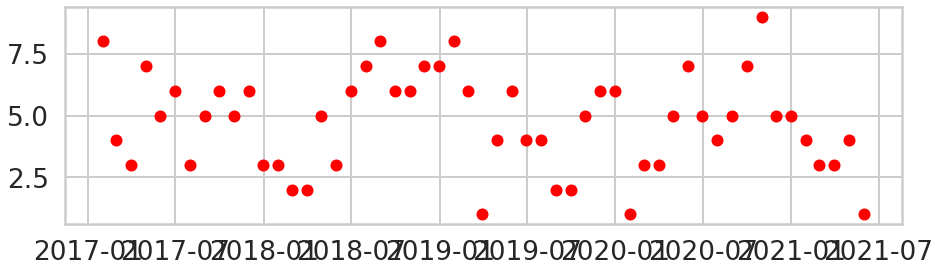

In [137]:
plt.scatter(date_rng[1:], zeros_by_month, s =100, c = 'red')

Lat 20°~41° and Lon -70°~-49°


Text(0.5, 0, 'Time (Monthly)')

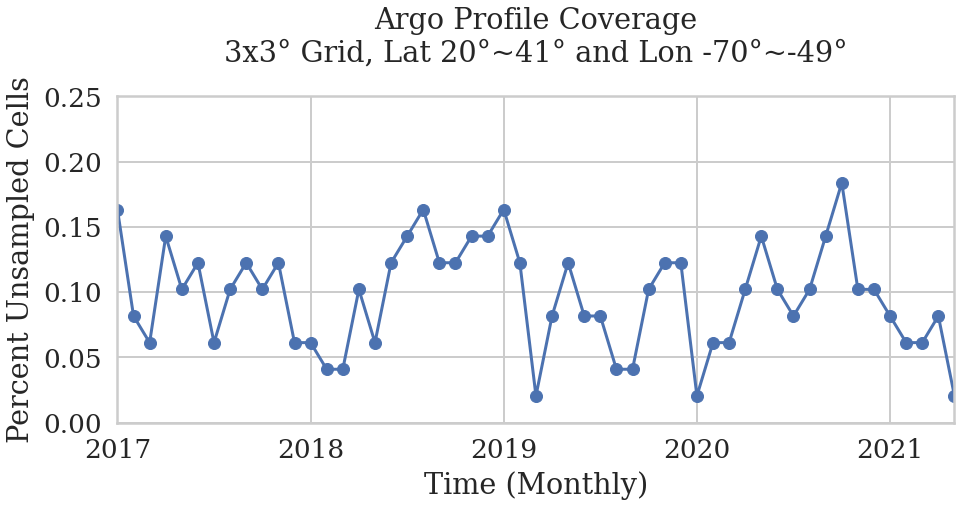

In [208]:

sns.set(rc={"figure.figsize":(15, 6)}) #width=3, #height=4
sns.set_context(context='poster', font_scale=1.2)
sns.set_style("whitegrid")
sns.set_style({'font.family':'serif'})

df = pd.DataFrame()
df['Date'] = date_rng[1:]
df['Percent Not Sampled'] = zeros_by_month 
df['Percent Not Sampled'] = df['Percent Not Sampled'] / num_total_grids
df[['Date','Percent Not Sampled']].set_index('Date').plot(
    marker='o',
#    title='Argo Profile Sparsity\n',
#    xlabel='Month',
#    ylabel='Percent Not Sampled',
    legend=False,
    ylim=(0,.25))
#( LIMITS['lat1'], LIMITS['lat2'], LIMITS['lon1'], LIMITS['lon2'])
L = LIMITS
fmt_limits = f"Lat {L['lat1']}°~{L['lat2']}° and Lon {L['lon1']}°~{L['lon2']}°"
print(fmt_limits)
plt.title(f"Argo Profile Coverage\n3x3° Grid, {fmt_limits}", pad=35)
plt.ylabel('Percent Unsampled Cells', labelpad=8)
plt.xlabel('Time (Monthly)', labelpad=8)

<AxesSubplot:xlabel='Date', ylabel='Percent Not Sampled'>

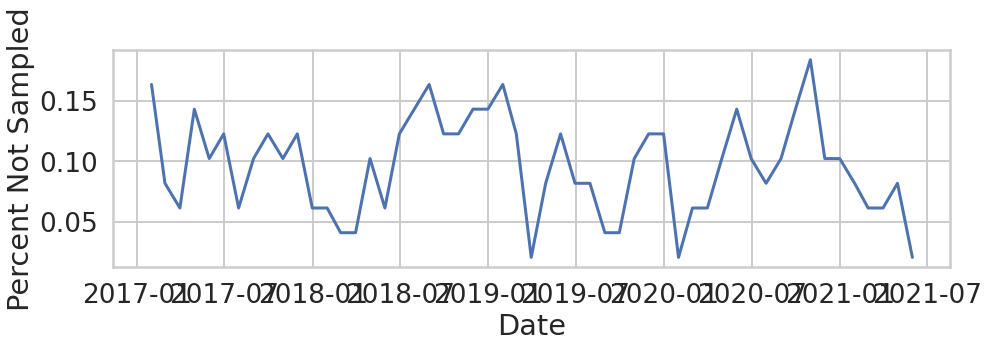

In [140]:
sns.lineplot(data=df, x="Date", y="Percent Not Sampled",markers=True,)
#sns.set(rc={"figure.figsize":(20, 8)}) #width=3, #height=4

/home/nrw/v3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'hi')

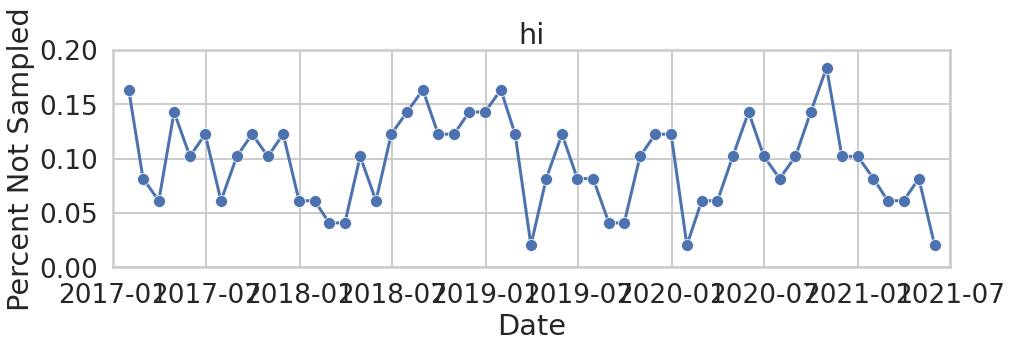

In [143]:
g = sns.lineplot('Date', 'Percent Not Sampled', data=df, linestyle='-', marker='o')
g.set(ylim=(0,0.2), xlim=(pd.to_datetime('2017-01-01'), pd.to_datetime('2021-07-01')))
plt.title('hi')